<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Семинар: рекомендательные системы - 2</center></h2>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import clear_output

# Рекомендация фильмов

В этом семинаре рассмотрим рекомендательную систему фильмов на основе нейронных сетей. Будем работать с данными, которые сожержат 1,000,209 анонимных рейтингов для примерно 3,900 фильмов от 6,040 пользователей MovieLens, которые присоединись в 2000.

**План семинара:**


1.   загрузим данные и посмотрим на них;
2.   обучим нейросетевую модель для рекомендаций Neural Collaborative Filtering (NCF);
3.   рассмотрим метрики качества рекомендаций;
4.   обучим модель классического машинного обучения  Factorization Machine (FM);
5.   сравним качество NCF и FM  по метрикам Hitrate@k и nDCG@k.



<center><img src="https://i.imgflip.com/1pvf4b.jpg" width="400"></center>

**Source:** https://grouplens.org/datasets/movielens/1m/

In [ ]:
# скачаем данные
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/movies.dat
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/users.dat
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/ratings.dat

--2022-04-18 23:55:03--  https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/movies.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171308 (167K) [text/plain]
Saving to: ‘movies.dat.1’

movies.dat.1        100%[===================>] 167.29K  --.-KB/s    in 0.02s   

2022-04-18 23:55:03 (7.41 MB/s) - ‘movies.dat.1’ saved [171308/171308]

--2022-04-18 23:55:03--  https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/users.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134368 (131K) [text/

### MOVIES FILE DESCRIPTION

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

    * Action
    * Adventure
    * Animation
    * Children's
    * Comedy
    * Crime
    * Documentary
    * Drama
    * Fantasy
    * Film-Noir
    * Horror
    * Musical
    * Mystery
    * Romance
    * Sci-Fi
    * Thriller
    * War
    * Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [ ]:
movies = pd.read_csv("movies.dat", sep="::", engine='python', header=None, encoding='latin-1')
movies.columns = ["MovieID", "Title", "Genres"]
movies.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### USERS FILE DESCRIPTION

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

    *  1:  "Under 18"
    * 18:  "18-24"
    * 25:  "25-34"
    * 35:  "35-44"
    * 45:  "45-49"
    * 50:  "50-55"
    * 56:  "56+"

- Occupation is chosen from the following choices:

    *  0:  "other" or not specified
    *  1:  "academic/educator"
    *  2:  "artist"
    *  3:  "clerical/admin"
    *  4:  "college/grad student"
    *  5:  "customer service"
    *  6:  "doctor/health care"
    *  7:  "executive/managerial"
    *  8:  "farmer"
    *  9:  "homemaker"
    * 10:  "K-12 student"
    * 11:  "lawyer"
    * 12:  "programmer"
    * 13:  "retired"
    * 14:  "sales/marketing"
    * 15:  "scientist"
    * 16:  "self-employed"
    * 17:  "technician/engineer"
    * 18:  "tradesman/craftsman"
    * 19:  "unemployed"
    * 20:  "writer"

In [ ]:
users = pd.read_csv("users.dat", sep="::", engine='python', header=None)
users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users.head(10)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


### RATINGS FILE DESCRIPTION

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [ ]:
ratings = pd.read_csv("ratings.dat", sep="::", engine='python', header=None)
ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings.head(10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


# Предобработанные данные

Для построения нашей рекомендательной системы мы будем использовать уже подготовленные данные. 

In [ ]:
# загружаем данные
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.negative
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.train.rating

--2022-04-18 23:55:10--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.negative
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2891424 (2.8M) [text/plain]
Saving to: ‘ml-1m.test.negative.1’

ml-1m.test.negative 100%[===================>]   2.76M  --.-KB/s    in 0.06s   

2022-04-18 23:55:11 (43.1 MB/s) - ‘ml-1m.test.negative.1’ saved [2891424/2891424]

--2022-04-18 23:55:11--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTT

Данные предварительно предобработаны:

**train.rating:**
- Train file.
- Each Line is a training instance: userID itemID rating timestamp (if have)

In [ ]:
train_data = pd.read_csv("ml-1m.train.rating", sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'], 
                         usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32})
train_data.head()

,user,item,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


In [ ]:
user_num = train_data['user'].max() + 1
item_num = train_data['item'].max() + 1

user_num, item_num

(6040, 3706)

In [ ]:
train_data = train_data[['user', 'item']].values.tolist()
train_data[:5]

[[0, 32], [0, 34], [0, 4], [0, 35], [0, 30]]

Матрица ретингов: строки - пользователи, столбцы - фильмы, на пересечении - 0 (не смотрел фильм) или 1 (смотрел).

In [ ]:
import scipy.sparse as sp

# load ratings as a dok matrix
train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
for x in train_data:
    train_mat[x[0], x[1]] = 1.0
    
# train_mat[userID, itemID] = 0 or 1

**test.rating:**
- Test file (positive instances). 
- Each Line is a testing instance: userID itemID rating timestamp (if have)

In [ ]:
test_data = pd.read_csv("ml-1m.test.rating", sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'], 
                         usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32})
test_data.head()

,user,item,rating,timestamp
0,0,25,5,978824351
1,1,133,3,978300174
2,2,207,4,978298504
3,3,208,4,978294282
4,4,222,2,978246585


**test.negative**
- Test file (negative instances).
- Each line corresponds to the line of test.rating, containing 99 negative samples.  
- Each line is in the format: (userID,itemID) negativeItemID1 negativeItemID2 ...

Это подготовленный набор данных, который мы будем использовать для тестирования нашей рекомендательной системы. Для каждого пользователя он содержит 1 фильм, который он смотрел, и 99 фильмов, которые он НЕ смотрел. Мы будем использовать их для подсчета метрик качества.

In [ ]:
test_data = []
with open("ml-1m.test.negative", 'r') as fd:
    line = fd.readline()
    while line != None and line != '':
        arr = line.split('\t')
        u = eval(arr[0])[0]
        test_data.append([u, eval(arr[0])[1]])
        for i in arr[1:]:
            test_data.append([u, int(i)])
        line = fd.readline()

In [ ]:
test_data[:5]

[[0, 25], [0, 1064], [0, 174], [0, 2791], [0, 3373]]

# Подготовка dataloaders

Реализуем специальный класс для работы с данными. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.utils.data as data

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
class NCFData(data.Dataset):
    
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(NCFData, self).__init__()
        
        """ Note that the labels are only useful when training, we thus 
            add them in the ng_sample() function.
        """
        
        self.features_ps = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.labels = [0 for _ in range(len(features))]

    
    def ng_sample(self):
        # добавляем фильмы, которые пользователь не смотрел.
        # это нужно для примеров 0-го класса при обучении.
        
        assert self.is_training, 'no need to sampling when testing'

        self.features_ng = []
        for x in self.features_ps:
            u = x[0]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        # тру метрки классов
        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    
    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    
    def __getitem__(self, idx):
        
        features = self.features_fill if self.is_training \
                    else self.features_ps
        labels = self.labels_fill if self.is_training \
                    else self.labels

        user = features[idx][0]
        item = features[idx][1]
        label = labels[idx]          # Нужны только для обучения. В тесте не используются.
        return user, item ,label

In [ ]:
train_dataset = NCFData(train_data, item_num, train_mat, num_ng=1, is_training=True)
test_dataset  = NCFData(test_data,  item_num, train_mat, num_ng=0, is_training=False)

In [ ]:
# попросим класс добавить num_ng негативных примеров (фильмы, которые не смотрел пользователь)
train_dataset.ng_sample() # для train_dataset num_ng=1

In [ ]:
# пример использования
print("User, Item, Label")

for idx, (user, item, label) in enumerate(train_dataset):
    print(user, item, label)
    if idx > 5: break

User, Item, Label
0 32 1
0 34 1
0 4 1
0 35 1
0 30 1
0 29 1
0 33 1


In [ ]:
# создадим даталоадеры для pytorch
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader  = data.DataLoader(test_dataset,  batch_size=100, shuffle=False, num_workers=0) # one user per batch !!!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Neural Collaborative Filtering (NCF)

### Matrix factorization algorithm

**NCF** - это нейронная модель матричной факторизации, которая объединяет **Generalized Matrix Factorization (GMF)** и **Multi-Layer Perceptron (MLP)**, объединяя в себе сильные стороны линейности MF и нелинейности MLP для моделирования скрытых структур user-item.

Схема архитектуры **NCF**:

<img src="https://miro.medium.com/max/1400/1*CoETyuU36fshduKAfFhCrg.png" width =900>

На схеме видно, как используются скрытые векторы пользователей и айтемов и как затем объединяются выходы из слоя **GMF** (слева) и слоя **MLP** (справа).

**Статья:** Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu & Tat-Seng Chua, Neural Collaborative Filtering, 2017 https://arxiv.org/abs/1708.05031

### 1 Модель GMF

В **ALS** матрицу оценок можно записать как:

$$\hat { r } _ { u , i } = q _ { i } ^ { T } p _ { u }$$

**GMF** представляет собой слой NCF как стандартный выходной слой MF. Поэтому MF может быть легко обобщена и расширена. Например, если мы позволим весам ребер выходного слоя обучаться без общего ограничения, то это даст вариант MF, который позволяет варьировать важность скрытых измерений. А если мы будем использовать нелинейную функцию активации, то это даст обобщение MF до нелинейной формы, которая может быть более выразительной, чем линейная MF модель. **GMF** может быть записана как:

$$\hat { r } _ { u , i } = a _ { o u t } \left( h ^ { T } \left( q _ { i } \odot p _ { u } \right) \right)$$

где $\odot$ - поэлементное произведение векторов, ${a}_{out}$ и ${h}$ обозначают функцию активации и веса ребер выходного слоя соответственно. MF может рассматриваться как частный случай GMF. Интуитивно, если мы используем тождественную функцию для ${a}_{out}$ и выбираем единичный вектор в качестве ${h}$, то мы в точности повторяем модель MF.

### 2 Модель MLP

NCF моделирует рейтинги двумя способами:
1.   поэлементное произведение векторов,
2.   конкатенация векторов.


Сразу после контатенации скрытых признаков пользователей и айтемов применяется стандартная модель MLP. Это дает возможность наделить модель большим уровнем гибкости и нелинейности для изучения взаимодействий между $p_{u}$ и $q_{i}$. 

Запишем модель **MLP** более строго.

Для входного слоя, используется конкатенация векторов пользователей и айтемов:

$$z _ { 1 } = \phi _ { 1 } \left( p _ { u } , q _ { i } \right) = \left[ \begin{array} { c } { p _ { u } } \\ { q _ { i } } \end{array} \right]$$

Для скрытых и выходного слоев MLP запись имеет вид:

$$
\phi _ { l } \left( z _ { l } \right) = a _ { o u t } \left( W _ { l } ^ { T } z _ { l } + b _ { l } \right) , ( l = 2,3 , \ldots , L - 1 )
$$



$$
\hat { r } _ { u , i } = \sigma \left( h ^ { T } \phi \left( z _ { L - 1 } \right) \right)
$$

где ${ W }_{ l }$, ${ b }_{ l }$, и ${ a }_{ out }$ обозначают матрицу весов, вектор свободных членов и функцию активации для $l$-ого слоя, соответственно. В качестве функций активации MLP слоев, мы вольны выбирать любую: сигмоиду, гиперболический тангенс, ReLU и другие. В качестве функции активации на выходном слое используется сигмоида $\sigma(x)=\frac{1}{1+e^{-x}}$, чтобы ограничить оценки диапазоном (0, 1).

### 3 Смешивание GMF и MLP

Чтобы обеспечить большую гибкость нашей смешанной модели, мы позволяем GMF и MLP обучать независимые эмбединги. Затем комбинируем две модели, объединяя их последние скрытие слои. Мы взяли $\phi^{GMF}$ из GMF:

$$\phi _ { u , i } ^ { G M F } = p _ { u } ^ { G M F } \odot q _ { i } ^ { G M F }$$

и получили $\phi^{MLP}$ из MLP:

$$\phi _ { u , i } ^ { M L P } = a _ { o u t } \left( W _ { L } ^ { T } \left( a _ { o u t } \left( \ldots a _ { o u t } \left( W _ { 2 } ^ { T } \left[ \begin{array} { c } { p _ { u } ^ { M L P } } \\ { q _ { i } ^ { M L P } } \end{array} \right] + b _ { 2 } \right) \ldots \right) \right) + b _ { L }\right.$$

Наконец, мы смешали выходы из GMF и MLP:

$$\hat { r } _ { u , i } = \sigma \left( h ^ { T } \left[ \begin{array} { l } { \phi ^ { G M F } } \\ { \phi ^ { M L P } } \end{array} \right] \right)$$

Модель сочетает линейность MF и нелинейность DNN при моделировании скрытых user–item структур.

### 4 Целевая функция

Мы можем записать функцию правдоподобия как:

$$P \left( \mathcal { R } , \mathcal { R } ^ { - } | \mathbf { P } , \mathbf { Q } , \Theta \right) = \prod _ { ( u , i ) \in \mathcal { R } } \hat { r } _ { u , i } \prod _ { ( u , j ) \in \mathcal { R } ^{ - } } \left( 1 - \hat { r } _ { u , j } \right)$$

где $\mathcal{R}$ обозначает множество наблюдаемых взаимодействий пользователя, а $\mathcal{ R } ^ { - }$ обозначает множество негативных наблюдений. $\mathbf{P}$ и $\mathbf{Q}$ - это скрытая матрица признаков пользователей и айтемов соответственно, $\Theta$ - параметры модели. Взяв со знаком минус логарифм от правдоподобия мы получим целевую функцию для минимизации NCF алгоритма. Что-то напоминает, не правда ли? https://en.wikipedia.org/wiki/Cross_entropy

$$L = - \sum _ { ( u , i ) \in \mathcal { R } \cup { \mathcal { R } } ^ { - } } r _ { u , i } \log \hat { r } _ { u , i } + \left( 1 - r _ { u , i } \right) \log \left( 1 - \hat { r } _ { u , i } \right)$$

In [ ]:
class NCF(nn.Module):
    def __init__(self, user_num, item_num, factor_num, num_layers,
                    dropout, model, GMF_model=None, MLP_model=None):
        super(NCF, self).__init__()
        
        """
        user_num: number of users;
        item_num: number of items;
        factor_num: number of predictive factors;
        num_layers: the number of layers in MLP model;
        dropout: dropout rate between fully connected layers;
        model: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
        GMF_model: pre-trained GMF weights;
        MLP_model: pre-trained MLP weights.
        """        
        
        self.dropout = dropout
        self.model = model
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model

        self.embed_user_GMF = nn.Embedding(user_num, factor_num)
        self.embed_item_GMF = nn.Embedding(item_num, factor_num)
        
        self.embed_user_MLP = nn.Embedding(user_num, factor_num * (2 ** (num_layers - 1)))
        self.embed_item_MLP = nn.Embedding(item_num, factor_num * (2 ** (num_layers - 1)))

        MLP_modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_modules.append(nn.Dropout(p=self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size//2))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)

        if self.model in ['MLP', 'GMF']:
            predict_size = factor_num 
        else:
            predict_size = factor_num * 2
        self.predict_layer = nn.Linear(predict_size, 1)

        self._init_weight_()

    
    def _init_weight_(self):
        
        """ We leave the weights initialization here. """
        
        if not self.model == 'NeuMF-pre':
            nn.init.normal_(self.embed_user_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
            nn.init.normal_(self.embed_item_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_item_MLP.weight, std=0.01)

            for m in self.MLP_layers:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
            
            nn.init.kaiming_uniform_(self.predict_layer.weight, a=1, nonlinearity='sigmoid')

            for m in self.modules():
                if isinstance(m, nn.Linear) and m.bias is not None:
                    m.bias.data.zero_()
        else:
            # embedding layers
            self.embed_user_GMF.weight.data.copy_(self.GMF_model.embed_user_GMF.weight)
            self.embed_item_GMF.weight.data.copy_(self.GMF_model.embed_item_GMF.weight)
            self.embed_user_MLP.weight.data.copy_(self.MLP_model.embed_user_MLP.weight)
            self.embed_item_MLP.weight.data.copy_(self.MLP_model.embed_item_MLP.weight)

            # mlp layers
            for (m1, m2) in zip(self.MLP_layers, self.MLP_model.MLP_layers):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            # predict layers
            predict_weight = torch.cat([
                self.GMF_model.predict_layer.weight, 
                self.MLP_model.predict_layer.weight], dim=1)
            
            precit_bias = self.GMF_model.predict_layer.bias + self.MLP_model.predict_layer.bias

            self.predict_layer.weight.data.copy_(0.5 * predict_weight)
            self.predict_layer.bias.data.copy_(0.5 * precit_bias)

    
    def forward(self, user, item):
        
        if not self.model == 'MLP':
            embed_user_GMF = self.embed_user_GMF(user)
            embed_item_GMF = self.embed_item_GMF(item)
            output_GMF = embed_user_GMF * embed_item_GMF
        
        if not self.model == 'GMF':
            embed_user_MLP = self.embed_user_MLP(user)
            embed_item_MLP = self.embed_item_MLP(item)
            interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
            output_MLP = self.MLP_layers(interaction)

        if self.model == 'GMF':
            concat = output_GMF
        elif self.model == 'MLP':
            concat = output_MLP
        else:
            concat = torch.cat((output_GMF, output_MLP), -1)

        prediction = self.predict_layer(concat)
        return prediction.view(-1)

In [ ]:
model = NCF(user_num, item_num, factor_num=32, num_layers=3, dropout=0.0, model='NeuMF-end')
model.to(DEVICE)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели

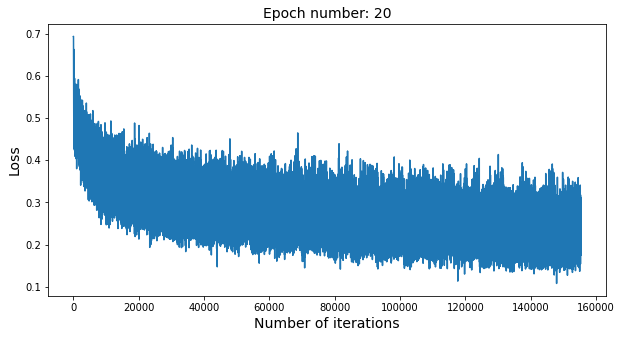

CPU times: user 25min 55s, sys: 2min 50s, total: 28min 45s
Wall time: 31min 7s


In [ ]:
%%time

loss_val = []

for epoch in range(1): # try more epoches (20)
    
    # Train
    model.train() # Enable dropout (if have).
    train_loader.dataset.ng_sample()

    for user, item, label in train_loader:
        user = user.to(DEVICE)
        item = item.to(DEVICE)
        label = label.float().to(DEVICE)

        model.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        
        
        # Plot learning curve
        loss_val.append(loss.cpu().detach().numpy())
        
        if len(loss_val) % 100 != 0: continue
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(loss_val)
        plt.xlabel("Number of iterations", size=14)
        plt.ylabel("Loss", size=14)
        plt.title("Epoch number: "+str(epoch+1), size=14)
        plt.show()

# Метрики качества

**Метрики качества предсказания событий:**

$$Hitrate@k = |R_u (k) \cap L_u|$$

$$Precision@k = \frac{|R_u (k) \cap L_u|}{|R_u (k)|}$$

$$Recall@k = \frac{|R_u (k) \cap L_u|}{|L_u|}$$

где $R_u$ (k) - список k лучших рекомендаций алгоритма; $L_u$ - список фильмов, которые пользователь реально посмотрел.


**Метрики качества ранжирования:**

$$ DCG@k =  \sum_{p=1}^{k} g(r_{ui_{p}}) d(p) $$

где $p$ - позиция фильма в списке рекомендаций; $g(r) = 2^r - 1$; $d(p) = \frac{1}{\log(p+1)}$.

$$ nDCG@k =  \frac{DCG@k}{max DCG@k}$$


**Конспект**: https://github.com/hse-ds/iad-applied-ds/blob/master/2020/lectures/lecture03-recommender.pdf

### Задание 1

Напишите функцию для подсчета `Hitrate@k`.

In [ ]:
def hit(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.
    
    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """
    ### YOUR CODE HERE ####
    if gt_item in pred_items:
        return 1
    return 0
    ### THE END ###########

### Задание 2

Напишите функцию для подсчета `nDCG@k`. Используйте $g(r) = 1$.

In [ ]:
def ndcg(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.
    
    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """
    ### YOUR CODE HERE ####
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0
    ### THE END ###########

### Задание 3

Напишите функцию, которая будет считать средние значения метрик качесвта на тестовых данных. Используйте `torch.topk()` и `torch.take()`.

In [ ]:
def metrics(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        
        ### YOUR CODE HERE ####
        user = user.to(DEVICE)
        item = item.to(DEVICE)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))
        ### THE END ###########

    return np.mean(HR), np.mean(NDCG)

Посчитаем метрики качества на тесте.

In [ ]:
model.eval()
HR, NDCG = metrics(model, test_loader, top_k=10)
HR, NDCG

(0.659933774834437, 0.3910553412410072)

# Factorization Machine (FM)

Авторы статьи https://arxiv.org/abs/2005.09683 утверждают, что NCF плохо учит произведение векторов. В результате, более простые методы демонстрируют лучшее качество рекомендаций. Сравним NCF c FM.

<img src="https://s3-us-west-1.amazonaws.com/sijunhe-blog/plots/post15/fm_example.png">

Модель предполагает, что рейтинг $\hat{y}(x)$ зависит от вектора признаков следующим образом:
$$\hat{y}(x) = w_0 + \sum_{i=1}^{n}w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} <v_i, v_j> x_i x_j$$

**Конспект:** https://github.com/hse-ds/iad-applied-ds/blob/master/2020/lectures/lecture02-recommender.pdf

In [ ]:
!pip install git+https://github.com/coreylynch/pyFM

  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-yzwz7p7_
  Running command git clone -q https://github.com/coreylynch/pyFM /tmp/pip-req-build-yzwz7p7_


In [ ]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

## Подготовка данных
Приведем обучающую выборку к нужному формату.

In [ ]:
train_dataset_fm = []
y_train = []

for i in range(0, len(train_dataset.features_fill), 10): # весь датасет может сломать pyfm !!!
    user, item = train_dataset.features_fill[i]
    label      = train_dataset.labels_fill[i]
    train_dataset_fm += [{'user': str(user), 'item': str(item)}]
    y_train += [label]

In [ ]:
# пример
train_dataset_fm[:5]

[{'item': '32', 'user': '0'},
 {'item': '23', 'user': '0'},
 {'item': '13', 'user': '0'},
 {'item': '45', 'user': '0'},
 {'item': '44', 'user': '0'}]

In [ ]:
# пример
y_train[:5]

[1, 1, 1, 1, 1]

## Обучение FM

In [ ]:
# переведем словарь в метрицу векторов x
v = DictVectorizer()
X_train = v.fit_transform(train_dataset_fm)
y_train = np.array(y_train)

In [ ]:
%%time
# обучение
# try more num_iter (100)
fm = pylibfm.FM(num_factors=32, num_iter=20, verbose=True, task="classification", 
                initial_learning_rate=0.01, learning_rate_schedule="optimal")
fm.fit(X_train, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training log loss: 0.66187
-- Epoch 2
Training log loss: 0.61068
-- Epoch 3
Training log loss: 0.57738
-- Epoch 4
Training log loss: 0.55402
-- Epoch 5
Training log loss: 0.53674
-- Epoch 6
Training log loss: 0.52354
-- Epoch 7
Training log loss: 0.51310
-- Epoch 8
Training log loss: 0.50469
-- Epoch 9
Training log loss: 0.49784
-- Epoch 10
Training log loss: 0.49206
-- Epoch 11
Training log loss: 0.48711
-- Epoch 12
Training log loss: 0.48290
-- Epoch 13
Training log loss: 0.47910
-- Epoch 14
Training log loss: 0.47571
-- Epoch 15
Training log loss: 0.47271
-- Epoch 16
Training log loss: 0.46993
-- Epoch 17
Training log loss: 0.46729
-- Epoch 18
Training log loss: 0.46491
-- Epoch 19
Training log loss: 0.46261
-- Epoch 20
Training log loss: 0.46045
-- Epoch 21
Training log loss: 0.45829
-- Epoch 22
Training log loss: 0.45628
-- Epoch 23
Training log loss: 0.45436
-- Epoch 24
Training log loss: 0.452

## Измерение качества

### Задание 4

Напишите функцию, которая будет считать средние значения метрик качесвта на тестовых данных. Используйте `torch.topk()` и `torch.take()`.

In [ ]:
def metricsFM(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        
        ### YOUR CODE HERE ####
        ui = [{'user': str(u), 'item': str(i)} for (u, i) in zip(user.detach().numpy(), item.detach().numpy())]
        predictions = model.predict(v.transform(ui))
        _, indices = torch.topk(torch.tensor(predictions), top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))
        ### THE END ###########

    return np.mean(HR), np.mean(NDCG)

In [ ]:
HR, NDCG = metricsFM(fm, test_loader, top_k=10)
HR, NDCG

(0.44387417218543046, 0.2400342014620534)

# Вопросы:
- Какой из алгоритмов лучше?
- Как вы думаете почему?

# Ссылки

- Тетрадка реализовна на основе кода https://github.com/guoyang9/NCF.